In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import pickle
import glob
import gzip
import scipy
import time
import gc

import os


In [5]:
year = 2019
zfilln = 3 # for file names  

# set directories for results and comb contents
resultsdir = '/Volumes/JD-SSD/bees/beeresults2019/'
comb_contents_dir = '/Volumes/JD-SSD/bees/comb-contents-images2019/'
    
# If the files 'datafunctions.py', 'definitions_2019.py', and 'displayfunctions.py' are in a different folder, need to cd there so can import them
# %cd '../'

import definitions_2019 as bd  
import displayfunctions as bp  # 'bee plots'
import datafunctions as dfunc
# import data_and_embedding
dfunc.init(bd) 
bp.init(bd)
# import data_and_embedding2019 as de  # data_and_embedding2019.py
bd.year

/Users/jacob/Seafile/Bees_sharedcodes/JD-2019data/comb building - Github/definitions_2019.py:29: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  cohort_birthdates = np.array([pd.Timestamp(np.array(cohort_data['DOB'][cohort_data['cohort']==c])[0],freq='D') for c in cohort_colornames])


2019

# Definitions

In [6]:
combdays1 = np.arange(0,23)
combdays2 = np.arange(42,65)
label_combdays1, label_combdays2 = 'combdays1', 'combdays2'

In [5]:
# determine when the feeder was on and off ()
startday=-1
feederon_ranges = []
day = bd.feederondays[0]
for j in range(len(bd.feederondays)):
    diff = bd.feederondays[j]-day
    day = bd.feederondays[j]
    if (diff==1) & (startday==-1):
        startday=day-1
    if diff>1:
        feederon_ranges.append([startday,bd.feederondays[j-1]])
        startday=day
feederon_ranges.append([startday,bd.feederondays[-1]])
print(feederon_ranges)
addedbees_days = [42,44,45,46]
addedcohorts_days = np.arange(bd.numdays)[[bd.alldaytimestamps[i] in bd.cohort_birthdates for i in np.arange(bd.numdays)]]
print('new cohorts were introduced on these days: ',addedcohorts_days)

[[2, 5], [14, 16], [19, 20], [36, 48], [56, 59]]
new cohorts were introduced on these days:  [  2   7  11  15  19  23  27  34  38  42  47  51  55  59  63  68  72  73
  78  82  86  91  97 103 110]


# Data import and processing

In [219]:
testcombdays1 = np.arange(5,12)
label_test = 'combtest'

In [249]:
recalc=True

daystoload = combdays1
labelbase = label_combdays1

firstday = daystoload[0]  # these need to be in order!
numtimedivs=24 # 24->1 hour, 288->5 min, 1440->1 min
savefile = resultsdir+labelbase+'.pkl'

if recalc:
    # load per-hour data
    prefix = 'dayhour'
    for i,daynum in enumerate(daystoload):
        filename = resultsdir+'df_'+prefix+'_'+str(daynum).zfill(zfilln)+'.hdf'
        if i==0:
            df = pd.read_hdf(filename)
        else:
            df = df = pd.concat((df,pd.read_hdf(filename) ))

    # assign integer hournumber, starting from the first day loaded
    df['HourInteger'] = (df['Day number'] - firstday)*24 + df['Hour']

    ## Calculate time outside and transitions using 1-minute data, and then save this back in the dataframe
    # calculate outside, and save it back in the 1 min dataframe
    obs_threshold=5
    exitdistthreshold=1500
    substratefrac_threshold=0.5
    close_when_back = True  # improves in-out estimates, by requiring close also when 
    for daynum in daystoload:
        print(daynum)
        filename = resultsdir+'df_'+'day1min'+'_'+str(daynum).zfill(zfilln)+'.hdf'
        filename_appended = filename.split('.')[0]+'-appended.hdf'
        dfday = pd.read_hdf(filename)
        ## outside
        day_uids, day_ages, all_inhive, bee_obs, bee_exitdist,_ = dfunc.get_inout_estimates(
            dfday, obs_threshold=obs_threshold, exitdistthreshold=exitdistthreshold,numtimedivs=1440,close_when_back=True)
        outofhive_hourmeans = np.mean(np.reshape(1-all_inhive,(all_inhive.shape[0],24,60)),axis=-1)
        wentoutside = np.insert(np.diff(all_inhive,axis=1)==-1,0,0,axis=1)
        numtrips_hoursums = np.sum(np.reshape(wentoutside,(all_inhive.shape[0],24,60)),axis=-1)
        ## substrates
        substrates_for_on = ['Festoon','topframe','Brood care','Honey','Frame 5']
        substrate_hourmeans = []
        for substratename in substrates_for_on:
            day_uids, day_ages, all_on, bee_obs, bee_data, bee_dfindex = dfunc.get_onsubstrate(dfday, obs_threshold, substratefrac_threshold, substratename=substratename,numtimedivs=1440)
            dfday.loc[bee_dfindex.flatten(),'On '+substratename] = all_on.flatten()         
            substrate_hourmeans.append(np.mean(np.reshape(all_on,(all_on.shape[0],24,60)),axis=-1))
        
        ## set it back in hour dataframe
        # this is slower but more transparent in what it does
        for i,u in enumerate(day_uids):
            beesel = (df['Day number']==daynum)&(df['Bee unique ID']==u)
            df.loc[beesel,'Out of hive fraction (day1min)'] = outofhive_hourmeans[i]
            df.loc[beesel,'Num. outside trips (day1min)'] = numtrips_hoursums[i]
            for substratename,values in zip(substrates_for_on,substrate_hourmeans):
                df.loc[beesel,substratename+'-main'] = values[i]
                
        # save dfday, so that could import easy later
        dfday.to_hdf(filename_appended,key='dfday', mode='w',complevel=5)

    # convert units
    qs = ['Median speed', 'Speed 90th quantile', 'Dispersion (avg)','Exit distance (median)', 'Dispersion-minute avg.'] # cm
    for q in qs:
        df[q] = df[q]/bd.pixels_per_cm            
    df['Festoon'] = df['Festoon'] / df['Num. observations']
    df['Empty comb'] = df['Empty comb']/ df['Num. observations']  
    
    df = df.reset_index(drop=True)
            
    pickle.dump(df,open(savefile,'wb'))
    print('wrote to:',savefile)
else:
    df = pickle.load(open(savefile,'rb'))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
wrote to: /Volumes/JD-SSD/bees/beeresults2019/combdays1.pkl


## Calculate overall comb substrate fractions and save

In [272]:
recalc = False

if recalc:

    def calc_overall_substrates(comb):
        overall_comb_substrates = np.zeros(bd.numsubstrates)
        w = [1,0] if comb.nummaps==1 else comb.weights
        for snum in range(bd.numsubstrates):
            overall_comb_substrates[snum] = np.mean(comb.substrate_maps[0]==snum) if comb.nummaps==1 else (np.mean(comb.substrate_maps[0]==snum)*w[0] + np.mean(comb.substrate_maps[1]==snum)*w[1])
        return overall_comb_substrates

    print(bd.comb_daynums)
    substrates = []
    for daynum in bd.comb_daynums:
        # print(daynum)
    #     comb = dfunc.day_comb_data(comb_contents_dir,bd.alldaytimestamps[daynum])
        comb = pickle.load(gzip.open(comb_contents_dir+'comb_'+str(daynum).zfill(zfilln)+'.pklz','rb'))
    #     bp.showcomb(comb)
    #     plt.title(bd.alldaytimestamps[daynum],fontsize=20)
    #     plt.show()
        subs = calc_overall_substrates(comb)
        substrates.append(subs)

    if year==2018:
        dancefloorcomb,hull = pickle.load(gzip.open(comb_contents_dir+'combined_dancefloor.pklz','rb'))  
        dancesubs = calc_overall_substrates(dancefloorcomb)

    # Store the overall substrates in a day-format
    all_overall_comb_substrates = np.zeros((bd.numdays,bd.numsubstrates))
    all_overall_comb_substrates[bd.comb_daynums,:] = substrates
    if year==2018:
        all_overall_comb_substrates[:,5] = dancesubs[5]
    # linear interpolation between the comb measurements
    days_to_use = bd.comb_daynums
    for i in range(len(days_to_use)-1):
        d1 = days_to_use[i]
        d2 = days_to_use[i+1]
        for snum in range(bd.numsubstrates):
            interp = np.interp(np.arange(d1,d2+1),[d1,d2],[all_overall_comb_substrates[d1,snum],all_overall_comb_substrates[d2,snum]])
            all_overall_comb_substrates[d1:d2,snum] = interp[:-1]

    # for the last measurement, set all equal to it
    all_overall_comb_substrates[bd.comb_daynums[-1]:] = all_overall_comb_substrates[bd.comb_daynums[-1]]

    # save to file
    pickle.dump([all_overall_comb_substrates],open(resultsdir+'all_overall_comb_substrates.pkl','wb'))
else:
    [all_overall_comb_substrates] = pickle.load(open(resultsdir+'all_overall_comb_substrates.pkl','rb'))

## comb contents averages - convert to simple substrates, and create dfsubstrates

In [273]:
bd.substrate_names

['Honey',
 'Capped brood',
 'Young brood',
 'Empty comb',
 'Pollen stores',
 'Dance floor',
 'Wooden frames',
 'Peripheral galleries',
 'blank space',
 'honey-dc',
 'capped brood-dc',
 'young brood-dc',
 'empty comb-dc',
 'festoon',
 'white']

In [274]:
all_overall_comb_substrates = all_overall_comb_substrates[0:bd.numdays]

substrate_names_simple = ['Honey','Brood care','Pollen','Empty comb','Festoon','Drone comb (any use)','Blank space','Other']
all_substrates_simple = np.zeros((bd.numdays,len(substrate_names_simple)))  # just has 5
all_substrates_simple[:,0] = all_overall_comb_substrates[:,0]  # honey
all_substrates_simple[:,1] = np.sum(all_overall_comb_substrates[:,1:3],axis=1)  # brood
all_substrates_simple[:,2] = all_overall_comb_substrates[:,4]  # pollen
all_substrates_simple[:,3] = all_overall_comb_substrates[:,3]  # empty
all_substrates_simple[:,4] = all_overall_comb_substrates[:,13]  # festoon
all_substrates_simple[:,5] = np.sum(all_overall_comb_substrates[:,9:13],axis=1)  # drone comb (any)
all_substrates_simple[:,6] = all_overall_comb_substrates[:,8]  # blank space
all_substrates_simple[:,-1] = 1 - np.sum(all_substrates_simple,axis=1)

# create dictionary of colors, so can access more easily
substrate_colors = dict(zip(substrate_names_simple,np.array(bd.comb_color_palette)[[0,2,4,3,13,10,8,6]]))
# convert np array to pandas df, to make access more transparent
dfsubstrates = pd.DataFrame(all_substrates_simple,columns=substrate_names_simple)
dfsubstrates['Day number'] = np.arange(bd.numdays)
dfsubstrates = dfsubstrates.set_index('Day number')
dfsubstrates.head()

,Honey,Brood care,Pollen,Empty comb,Festoon,Drone comb (any use),Blank space,Other
Day number,,,,,,,,
0,0.035498,0.135816,0.024132,0.252751,0.000000,0.000000,0.238521,0.313282
1,0.056984,0.138257,0.018582,0.234428,0.000000,0.000000,0.238474,0.313275
2,0.131542,0.172369,0.013288,0.131249,0.000000,0.000000,0.238471,0.313081
3,0.153996,0.217201,0.017385,0.059856,0.000000,0.000013,0.238531,0.313019
4,0.146518,0.259915,0.034385,0.017230,0.089958,0.000037,0.145396,0.306562


# Plot number of bees on substrates over time

In [254]:
maxobspertimediv = 24*60*60*3 / numtimedivs

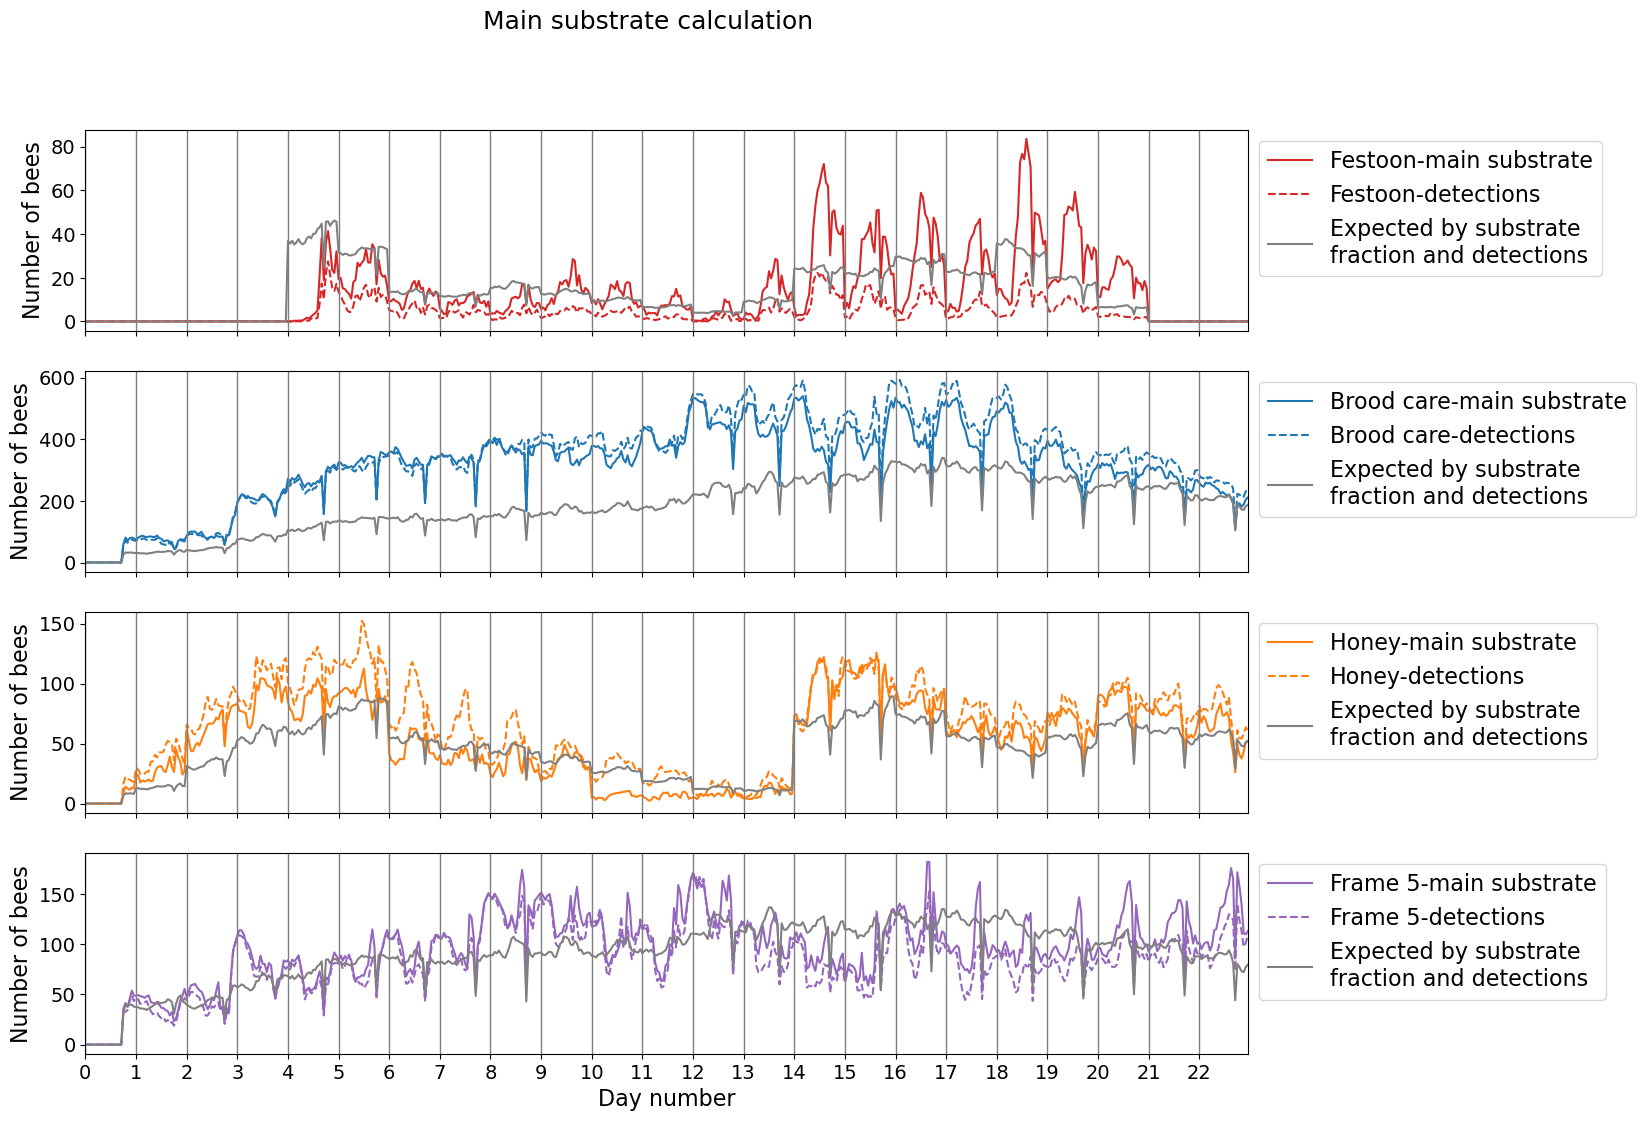

In [263]:
toplot = ['Festoon','Brood care','Honey','Frame 5']
colors = bp.snscolors[[3,0,1,4]]
tpx = np.linspace(daystoload[0],daystoload[-1]+1,len(daystoload)*numtimedivs+1)[0:-1]

f,ax = plt.subplots(len(toplot),1,sharex=True)
f.set_size_inches(15,3*len(ax))

for a,metric,color in zip(ax,toplot,colors):
    # metric = 'Festoon'
    x = df['HourInteger']
    y = df[metric] * df['Num. observations'] / maxobspertimediv
    y_main = df[metric+'-main'] * df['Num. observations'] / maxobspertimediv

    timebins = np.arange(np.max(x)+2)-0.5
    # observation-weighted number of bees estimates
    mainsubstrate = scipy.stats.binned_statistic(x,y_main,bins=timebins,statistic=(lambda z: np.nansum(z)))[0]
    simpledetection = scipy.stats.binned_statistic(x,y,bins=timebins,statistic=(lambda z: np.nansum(z)))[0]
    # total number of detections relative to max possible
    totalobs = scipy.stats.binned_statistic(x,df['Num. observations'],bins=timebins,statistic=(lambda z: np.nansum(z)))[0]
    # total num bees counted in each time bin
    totalnumbees = scipy.stats.binned_statistic(x,x,bins=timebins,statistic='count')[0]

    a.plot(tpx,mainsubstrate,color=color,linestyle='-',label=(metric+'-main substrate'))
    a.plot(tpx,simpledetection,color=color,linestyle='--',label=(metric+'-detections'))
    if metric in substrate_colors.keys():
        # use (totalobs/maxobmaxobspertimediv) instead of (totaltotalnumbees), becuase the average detection rate is not perfect.  Can compare though
        substratefrac = dfsubstrates.loc[daystoload[0]:daystoload[-1],metric]
        days_to_timedivs = lambda x: np.tile(x,(numtimedivs,1)).T.flatten()
        a.plot(tpx,days_to_timedivs(substratefrac)*(totalobs/maxobspertimediv),color='grey',linestyle='-',label='Expected by substrate\nfraction and detections')
        # a.plot(tpx,days_to_timedivs(all_substrates_daysel[:,subfracind[0]])*(totalnumbees),color='grey',linestyle='--',label='expected by sub frac and num bees')
    else:  # for frame 5, its a single frame (1/6th)
        a.plot(tpx,1/6*(totalobs/maxobspertimediv),color='grey',linestyle='-',label='Expected by substrate\nfraction and detections')
        # a.plot(tpx,1/6*(totalnumbees),color='grey',linestyle='-',label='expected by sub frac and num bees')
    a.legend()
    
    
a=ax[-1]
a.set_xlim([tpx[0],tpx[-1]])
a.set_xlabel("Day number",fontsize=16)
for a in ax:
    a.tick_params(labelsize=14)
    a.set_ylabel('Number of bees',fontsize=16)
    a.legend(fontsize=16,bbox_to_anchor=(1,1))
    [a.axvline(j,c='grey',linewidth=1) for j in daystoload]
    a.set_xticks(daystoload)
plt.suptitle('Main substrate calculation',fontsize=18)

plt.show()

# Age/Activity on substrates over time (conditional)
- should calculate this with both hour and 1min, and compare
- if hour (with some threshold) if sufficient, then use this - its MUCH easier.
- also check with the threhold definition part below

## Calculate using hour data

### Determine reasonable threshold for festoon

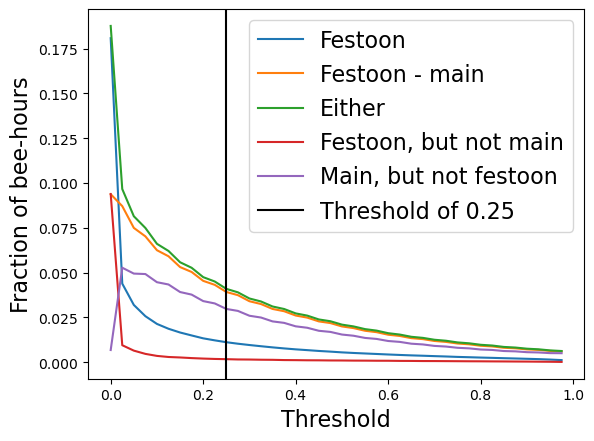

In [334]:
thresholds = np.arange(0,1,0.025)
counts_f = [np.sum(df['Festoon']>t) for t in thresholds]
counts_m = [np.sum(df['Festoon-main']>t) for t in thresholds]
counts_both = [np.sum((df['Festoon-main']>t)|(df['Festoon']>t)) for t in thresholds]
counts_fnotm = [np.sum(np.logical_not(df['Festoon-main']>t)&(df['Festoon']>t)) for t in thresholds]
counts_mnotf = [np.sum(np.logical_not(df['Festoon']>t)&(df['Festoon-main']>t)) for t in thresholds]
gf = lambda x: np.array(x)/len(df)
plt.plot(thresholds, gf(counts_f),label="Festoon")
plt.plot(thresholds, gf(counts_m),label="Festoon - main ")
plt.plot(thresholds,gf(counts_both),label="Either")
plt.plot(thresholds,gf(counts_fnotm),label='Festoon, but not main')
plt.plot(thresholds,gf(counts_mnotf),label='Main, but not festoon')
plt.xlabel('Threshold',fontsize=16)
plt.ylabel('Fraction of bee-hours',fontsize=16)
threshold=0.25
plt.axvline(threshold,c='k',label='Threshold of '+str(threshold))
plt.legend(fontsize=16,bbox_to_anchor=(1,1))
plt.show()

### Set threshold for time on substrate, and use hour data to get conditional quantities

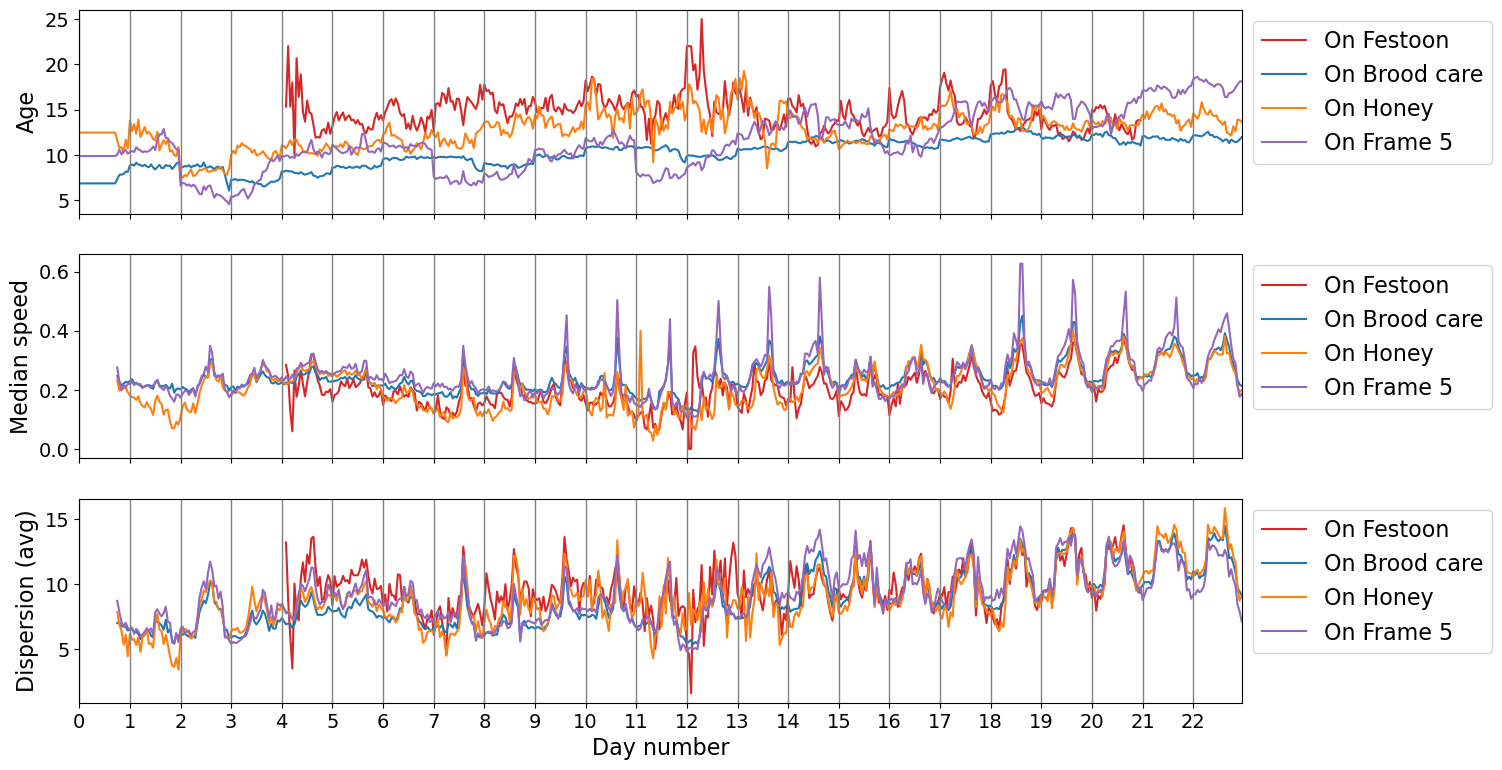

In [345]:
substrate_threshold = 0.25

toplot = ['Festoon','Brood care','Honey','Frame 5']
colors = bp.snscolors[[3,0,1,4]]
quantities_to_plot = ['Age','Median speed','Dispersion (avg)']

f,ax = plt.subplots(len(quantities_to_plot),1,sharex=True,sharey=False)
f.set_size_inches(15,3*len(quantities_to_plot))
tpx = np.linspace(daystoload[0],daystoload[-1]+1,len(daystoload)*numtimedivs+1)[0:-1]
timebins = np.arange(np.max(df['HourInteger'])+2)-0.5

avgfn = (lambda x: (np.nanmean(x) if (np.sum(np.logical_not(np.isnan(x)))>0) else np.nan))  # avoids error msg for empty slice of all nans
for a,q in zip(ax,quantities_to_plot):
    for substrate,color in zip(toplot,colors):
        dfsel = df[df[substrate+'-main']>=substrate_threshold]
        avg = scipy.stats.binned_statistic(dfsel['HourInteger'],dfsel[q],bins=timebins,statistic=avgfn)[0]
        a.plot(tpx,avg,label=('On '+substrate),color=color)
    
# Formatting    
a=ax[-1]
a.set_xlim([tpx[0],tpx[-1]])
# ax[1].set_ylim([0,50])
# ax[2].set_ylim([0,800])

a=ax[-1]
a.set_xlim([tpx[0],tpx[-1]])
a.set_xlabel("Day number",fontsize=16)
for a,label in zip(ax,quantities_to_plot):
    a.tick_params(labelsize=14)
    a.set_ylabel(label,fontsize=16)
    a.legend(fontsize=16,bbox_to_anchor=(1,1))
    [a.axvline(j,c='grey',linewidth=1) for j in daystoload]
    a.set_xticks(daystoload)    

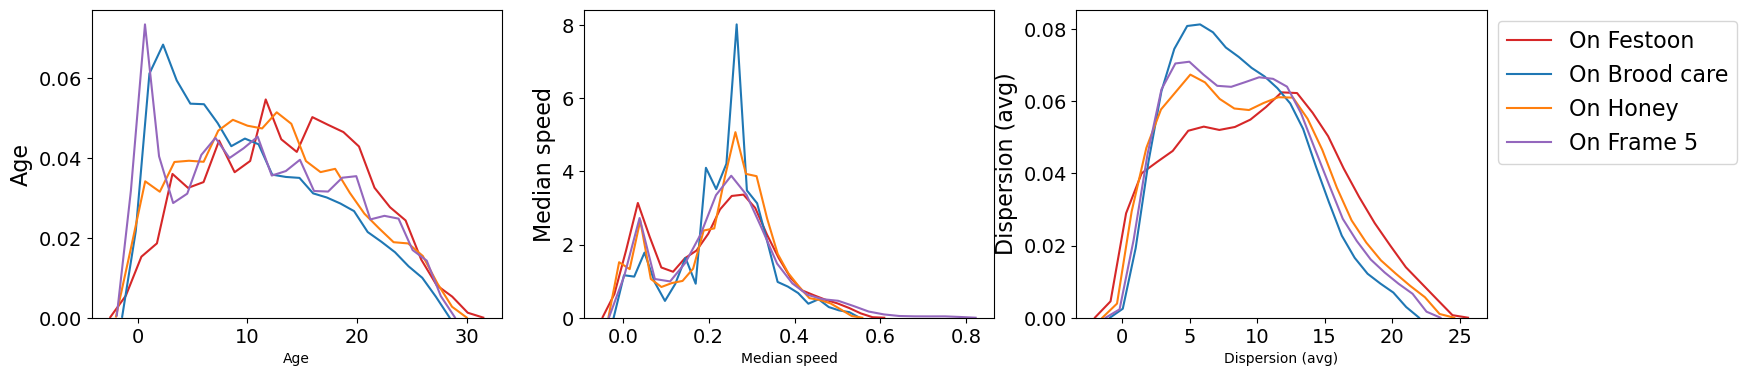

In [387]:
substrate_threshold = 0.25

quantities_to_plot = ['Age','Median speed','Dispersion (avg)']
toplot = ['Festoon','Brood care','Honey','Frame 5']

f,ax = plt.subplots(1,len(quantities_to_plot),sharex=False,sharey=False)
f.set_size_inches(6*len(quantities_to_plot),4)

for a,q in zip(ax,quantities_to_plot):
    for substrate,color in zip(toplot,colors):
        dfsel = df[df[substrate+'-main']>=substrate_threshold]
        # a.hist(dfsel[q],label=('On '+substrate),color=color,histtype='step',density=True)
        # filter outliers so the limits aren't huge
        dat = dfsel[q]
        sns.kdeplot(dat[dat<np.nanquantile(dat,0.99)],ax=a,color=color,gridsize=25,label='On '+substrate)


# formatting
for a,label in zip(ax,quantities_to_plot):
    a.tick_params(labelsize=14)
    a.set_ylabel(label,fontsize=16)
ax[-1].legend(fontsize=16,bbox_to_anchor=(1,1))

In [388]:
# Plot as violins

def setcolor(bplot,clr,alpha=1):
    for patch in bplot['boxes']:
        patch.set(color=clr,alpha=alpha)  
        patch.set_facecolor(clr)
    for element in ['whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bplot[element], color=clr,alpha=alpha)     
    plt.setp(bplot["fliers"], markeredgecolor=clr, markerfacecolor=clr,markersize=4,alpha=alpha)
def setcolorv(vplot,clr,alpha=1):
    for patch in vplot['bodies']:
        patch.set(color=clr,alpha=alpha)  
        patch.set_facecolor(clr)
        patch.set_edgecolor('black')        
        patch.set_alpha(alpha)

def vplotquantiles(a,dat,pos):
    quartile1, medians, quartile3 = np.percentile(dat, [25, 50, 75])
    a.scatter(medians, pos, marker='o', color='white', s=30, zorder=3)
    a.hlines(pos, quartile1, quartile3, color='k', linestyle='-', lw=5)

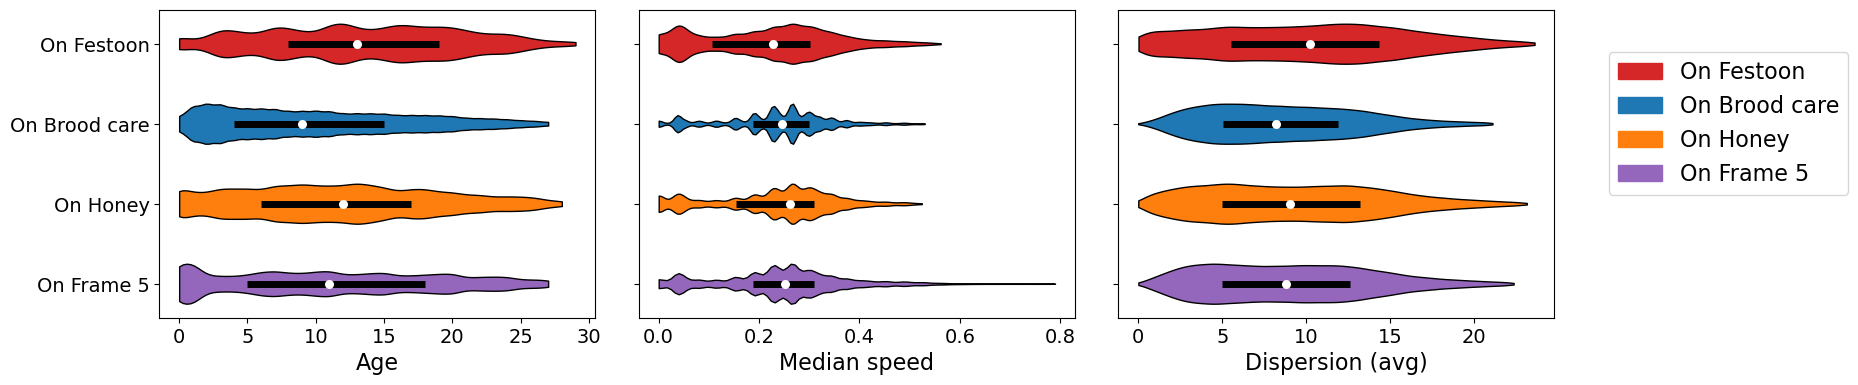

In [401]:
## Plot means
substrate_threshold = 0.25


quantities_to_plot = ['Age','Median speed','Dispersion (avg)']
toplot = ['Festoon','Brood care','Honey','Frame 5']

f,ax = plt.subplots(1,len(quantities_to_plot),sharex=False,sharey=True)
f.set_size_inches(6*len(quantities_to_plot),4)


for a,q in zip(ax,quantities_to_plot):
    for i, (substrate,color) in enumerate(zip(toplot,colors)):
        dfsel = df[df[substrate+'-main']>=substrate_threshold]
        # filter outliers so the limits aren't huge, and remove nans
        dat = dfsel[q]
        dat = dat[(dat<np.nanquantile(dat,0.99))&(np.logical_not(np.isnan(dat)))]
        vplot = a.violinplot(dat,positions=[-i], showextrema=False,vert=False)
        setcolorv(vplot,color)
        vplotquantiles(a,dat,-i)
        

for a,label in zip(ax,quantities_to_plot):
    a.tick_params(labelsize=14)
    a.set_xlabel(label,fontsize=16)
    a.set_yticks(-np.arange(len(toplot)))
onlabels = ['On '+q for q in toplot]        
ax[0].set_yticklabels(onlabels)

# legend by 'fake object'
import matplotlib.patches as mpatches
colorpatches = [mpatches.Patch(color=color) for color in colors]
# 'fake' invisible object
# fake_handles = repeat(red_patch, len(pos))
ax[-1].legend(colorpatches,onlabels,fontsize=16,bbox_to_anchor=(1.7,0.9))    
# ax[0].set_ylabel('Probability density',fontsize=16)    
plt.subplots_adjust(wspace=0.1)

plt.show()    

## Calculate using minute data

In [453]:
recalc = True
processed_filename = resultsdir+'minute-onsubstrate-'+labelbase+'.pkl'
if recalc:
    # create blank dataframes, and add to them while reading in the already-processed files
    quantities_to_save = ['TimeDivInteger','Bee unique ID','Age','Median speed','Dispersion (avg)']
    df_onfestoon, df_onbrood, df_onhoney, df_onframe5 = [pd.DataFrame(columns=quantities_to_save) for _ in range(4)]

    for daynum in daystoload:
        print(daynum)
        filename = resultsdir+'df_'+'day1min'+'_'+str(daynum).zfill(zfilln)+'.hdf'
        filename_appended = filename.split('.')[0]+'-appended.hdf'
        dfday = pd.read_hdf(filename_appended)
        dfday['TimeDivInteger'] = (dfday['Day number'] - firstday)*1440 + dfday['timedivision']
        # concatenate each one to keep
        df_onfestoon = pd.concat((df_onfestoon,dfday.loc[dfday['On Festoon']==1,quantities_to_save]))
        df_onbrood = pd.concat((df_onbrood,dfday.loc[dfday['On Brood care']==1,quantities_to_save]))
        df_onhoney = pd.concat((df_onhoney,dfday.loc[dfday['On Honey']==1,quantities_to_save]))
        df_onframe5 = pd.concat((df_onframe5,dfday.loc[dfday['On Frame 5']==1,quantities_to_save]))
    pickle.dump([df_onfestoon, df_onbrood, df_onhoney, df_onframe5], open(processed_filename,'wb'))  # this is slower to save but compresses 4x
else:
    [df_onfestoon, df_onbrood, df_onhoney, df_onframe5] = pickle.load(open(processed_filename,'rb'))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


In [ ]:
toplot = ['Festoon','Brood care','Honey','Frame 5']
dftoplot = [df_onfestoon, df_onbrood, df_onhoney, df_onframe5]
colors = bp.snscolors[[3,0,1,4]]
quantities_to_plot = ['Age','Median speed','Dispersion (avg)']

Age
Festoon
Brood care
Honey
Frame 5
Median speed
Festoon
Brood care
Honey
Frame 5
Dispersion (avg)
Festoon
Brood care
Honey
Frame 5


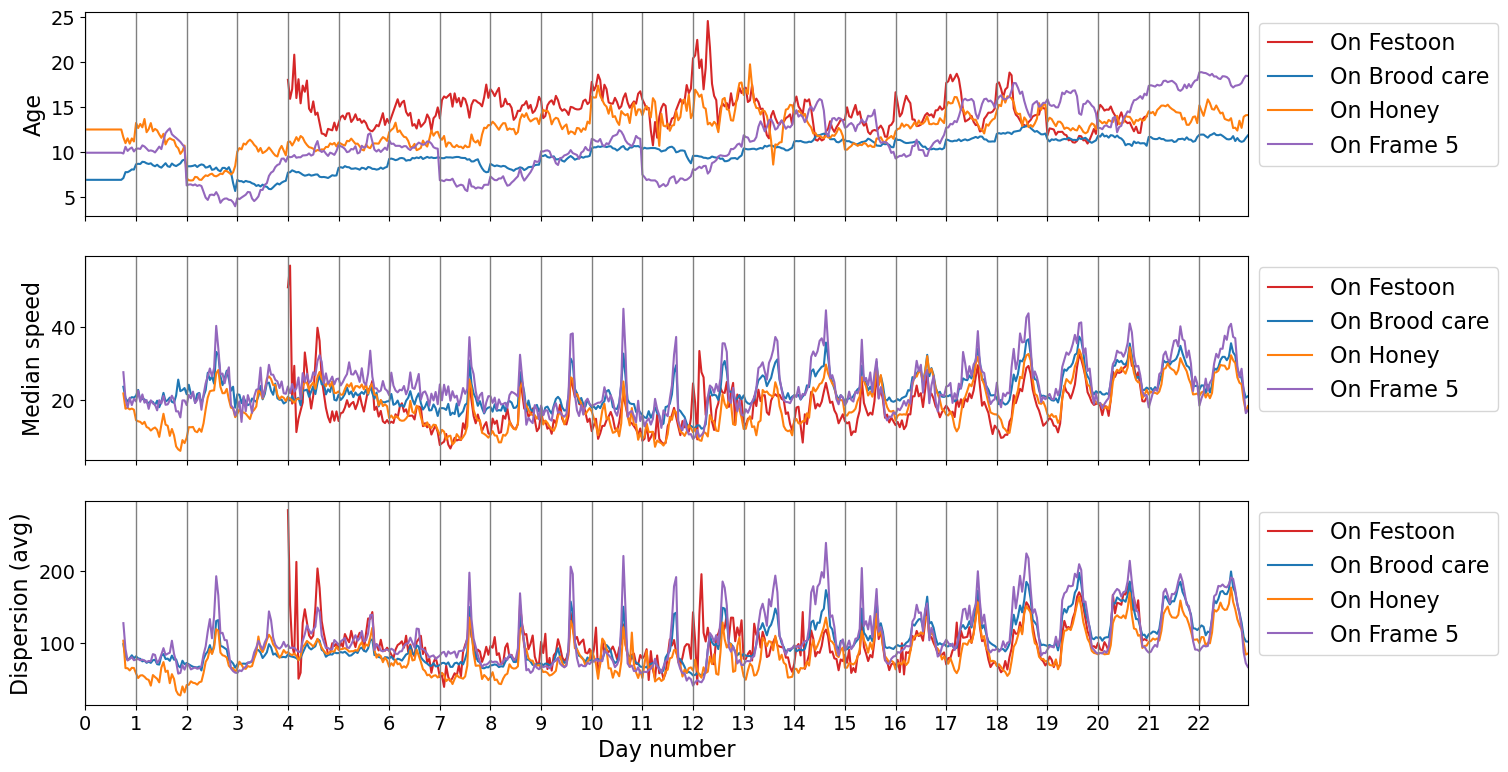

In [464]:
f,ax = plt.subplots(len(quantities_to_plot),1,sharex=True,sharey=False)
f.set_size_inches(15,3*len(quantities_to_plot))
tpx = np.linspace(daystoload[0],daystoload[-1]+1,len(daystoload)*numtimedivs+1)[0:-1]
timebins = np.arange(np.max(df['HourInteger'])+2)*60-0.5 #

avgfn = (lambda x: (np.nanmean(x) if (np.sum(np.logical_not(np.isnan(x)))>0) else np.nan))  # avoids error msg for empty slice of all nans
for a,q in zip(ax,quantities_to_plot):
    print(q)
    for substrate,color,dfsel in zip(toplot,colors,dftoplot):
        print('\t',substrate)
        avg = scipy.stats.binned_statistic(dfsel['TimeDivInteger'],dfsel[q],bins=timebins,statistic=avgfn)[0]
        a.plot(tpx,avg,label=('On '+substrate),color=color)
    
# Formatting    
a=ax[-1]
a.set_xlim([tpx[0],tpx[-1]])
# ax[1].set_ylim([0,50])
# ax[2].set_ylim([0,800])

a=ax[-1]
a.set_xlim([tpx[0],tpx[-1]])
a.set_xlabel("Day number",fontsize=16)
for a,label in zip(ax,quantities_to_plot):
    a.tick_params(labelsize=14)
    a.set_ylabel(label,fontsize=16)
    a.legend(fontsize=16,bbox_to_anchor=(1,1))
    [a.axvline(j,c='grey',linewidth=1) for j in daystoload]
    a.set_xticks(daystoload)    

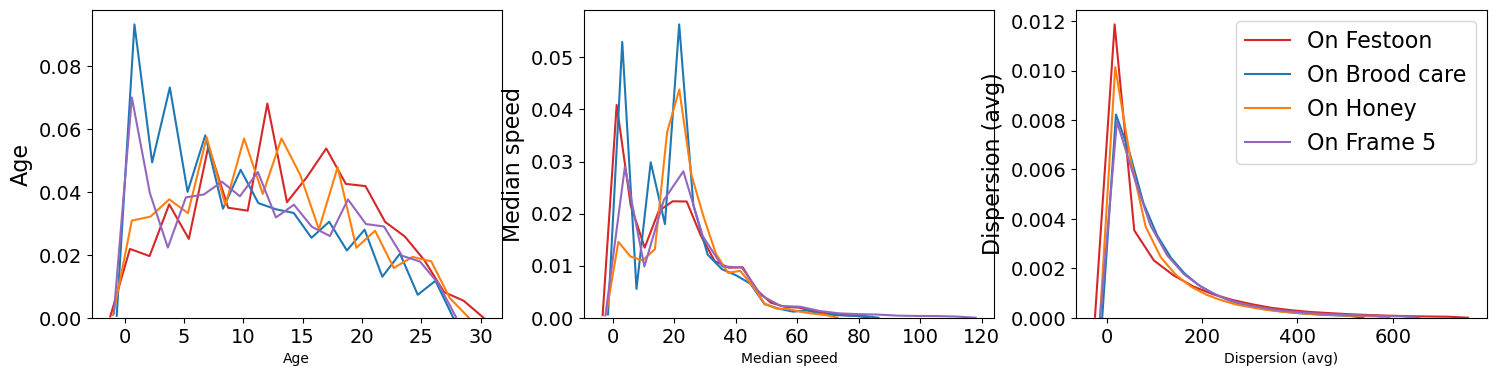

In [478]:
f,ax = plt.subplots(1,len(quantities_to_plot),sharex=False,sharey=False)
f.set_size_inches(6*len(quantities_to_plot),4)

for a,q in zip(ax,quantities_to_plot):
    for substrate,color,dfsel in zip(toplot,colors,dftoplot):
        # a.hist(dfsel[q],label=('On '+substrate),color=color,histtype='step',density=True)
        # filter outliers so the limits aren't huge
        dat = dfsel[q]
        sns.kdeplot(dat[dat<np.nanquantile(dat,0.99)],ax=a,color=color,gridsize=20,label='On '+substrate)

# formatting
for a,label in zip(ax,quantities_to_plot):
    a.tick_params(labelsize=14)
    a.set_ylabel(label,fontsize=16)
ax[-1].legend(fontsize=16,bbox_to_anchor=(1,1))

Festoon
Brood care
Honey
Frame 5
Festoon
Brood care
Honey
Frame 5
Festoon
Brood care
Honey
Frame 5


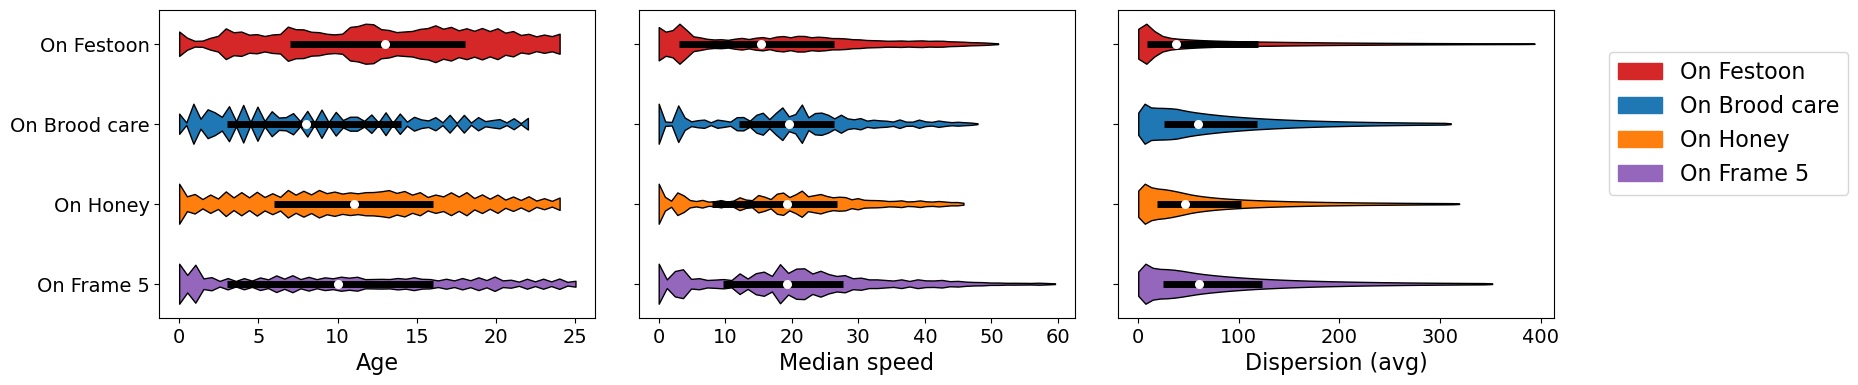

In [477]:
## Plot means

f,ax = plt.subplots(1,len(quantities_to_plot),sharex=False,sharey=True)
f.set_size_inches(6*len(quantities_to_plot),4)

for a,q in zip(ax,quantities_to_plot):
    for i, (substrate,color,dfsel) in enumerate(zip(toplot,colors,dftoplot)):
        print(substrate)
        # filter outliers so the limits aren't huge, and remove nans
        dat = dfsel[q]
        dat = dat[(dat<np.nanquantile(dat,0.95))&(np.logical_not(np.isnan(dat)))]
        vplot = a.violinplot(dat,positions=[-i], showextrema=False,vert=False,points=50)
        setcolorv(vplot,color)
        vplotquantiles(a,dat,-i)
        
for a,label in zip(ax,quantities_to_plot):
    a.tick_params(labelsize=14)
    a.set_xlabel(label,fontsize=16)
    a.set_yticks(-np.arange(len(toplot)))
onlabels = ['On '+q for q in toplot]        
ax[0].set_yticklabels(onlabels)

# legend by 'fake object'
import matplotlib.patches as mpatches
colorpatches = [mpatches.Patch(color=color) for color in colors]
# 'fake' invisible object
# fake_handles = repeat(red_patch, len(pos))
ax[-1].legend(colorpatches,onlabels,fontsize=16,bbox_to_anchor=(1.7,0.9))    
# ax[0].set_ylabel('Probability density',fontsize=16)    
plt.subplots_adjust(wspace=0.1)

plt.show()    

# Overall comb contents and substrates fractions plots

Text(0.5, 0.98, 'All substrates')

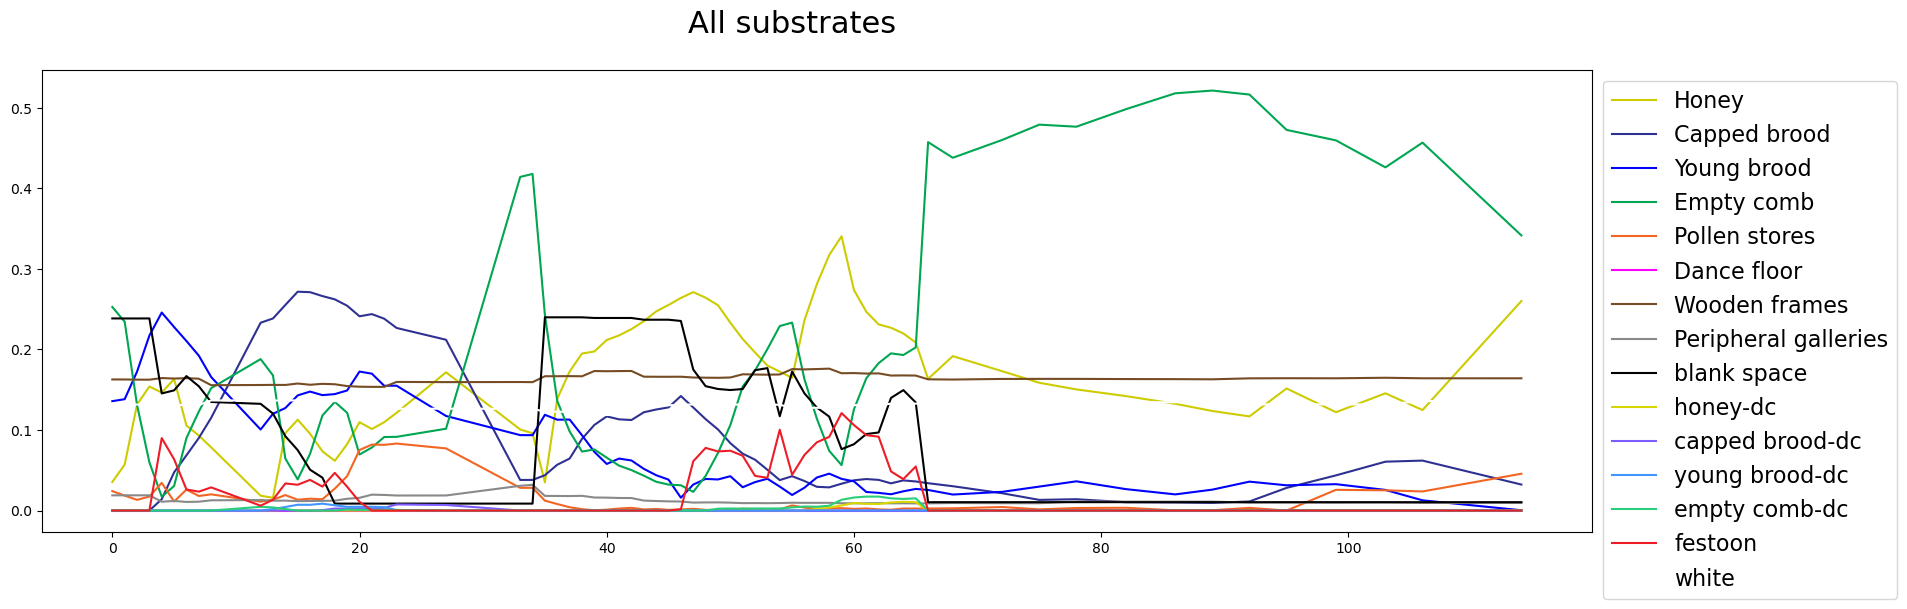

In [270]:
f,ax=plt.subplots(1,1)
f.set_size_inches(20,6)
for i in range(0,15):
    plt.plot(all_overall_comb_substrates[:,i],label=bd.substrate_names[i],color=bd.comb_color_palette[i])
plt.legend(bbox_to_anchor=(1,1),fontsize=16)
plt.suptitle("All substrates",fontsize=22)

Text(0.5, 0.98, 'Focus substrates - simple')

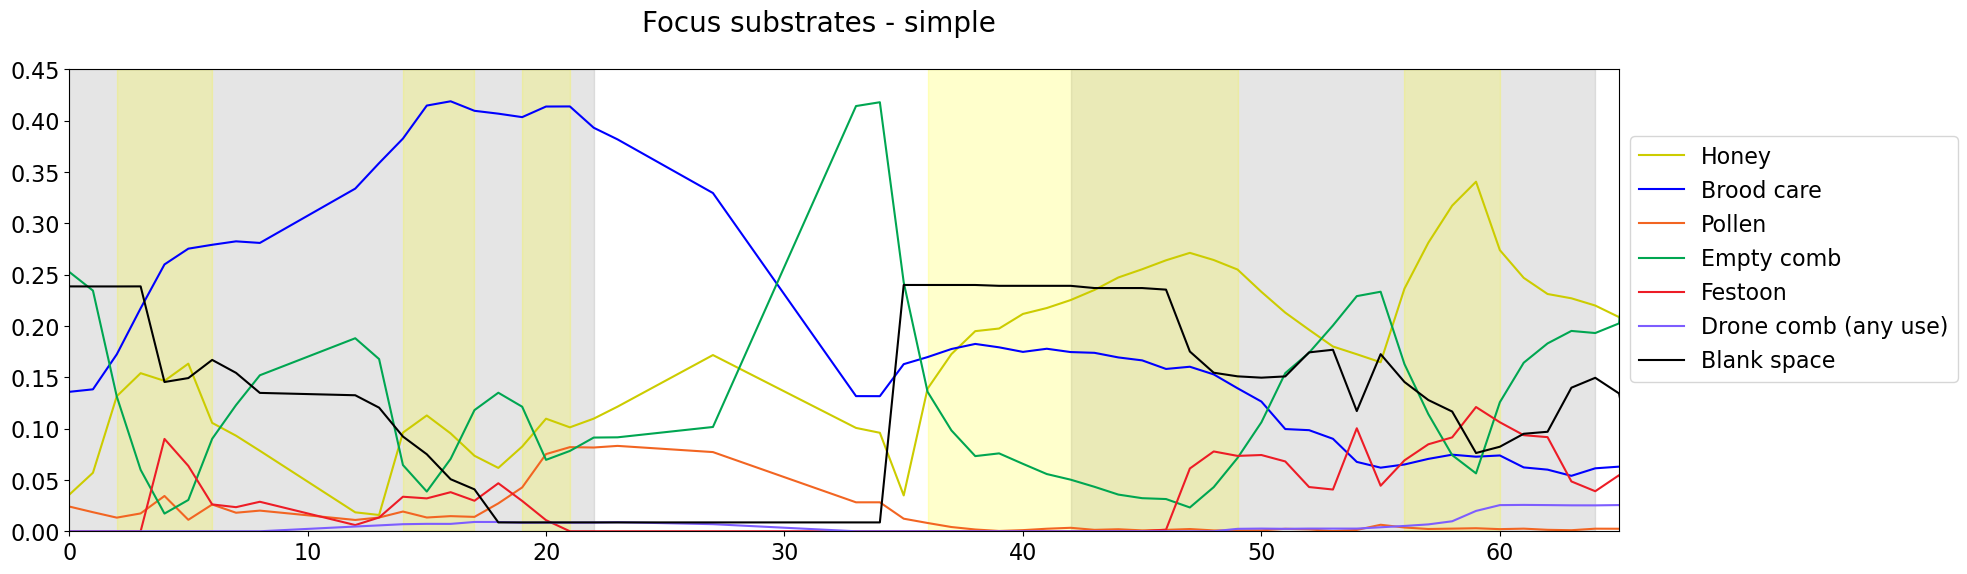

In [271]:
f,ax=plt.subplots(1,1)
f.set_size_inches(20,6)
for i in range(len(substrate_names_simple)-1):
    ax.plot(all_substrates_simple[:,i],label=substrate_names_simple[i],color=substrate_colors_simple[i])
ax.axvspan(combdays1[0],combdays1[-1],color='grey',alpha=0.2,zorder=-1)
ax.axvspan(combdays2[0],combdays2[-1],color='grey',alpha=0.2,zorder=-1)

[ax.axvspan(d[0],d[1]+1,color='yellow',alpha=0.2,zorder=0) for d in feederon_ranges]

ax.legend(bbox_to_anchor=(1,0.3),fontsize=16)
ax.tick_params(labelsize=16)
ax.set_xlim([0,65])
ax.set_ylim([0,0.45])
plt.suptitle('Focus substrates - simple',fontsize=20)

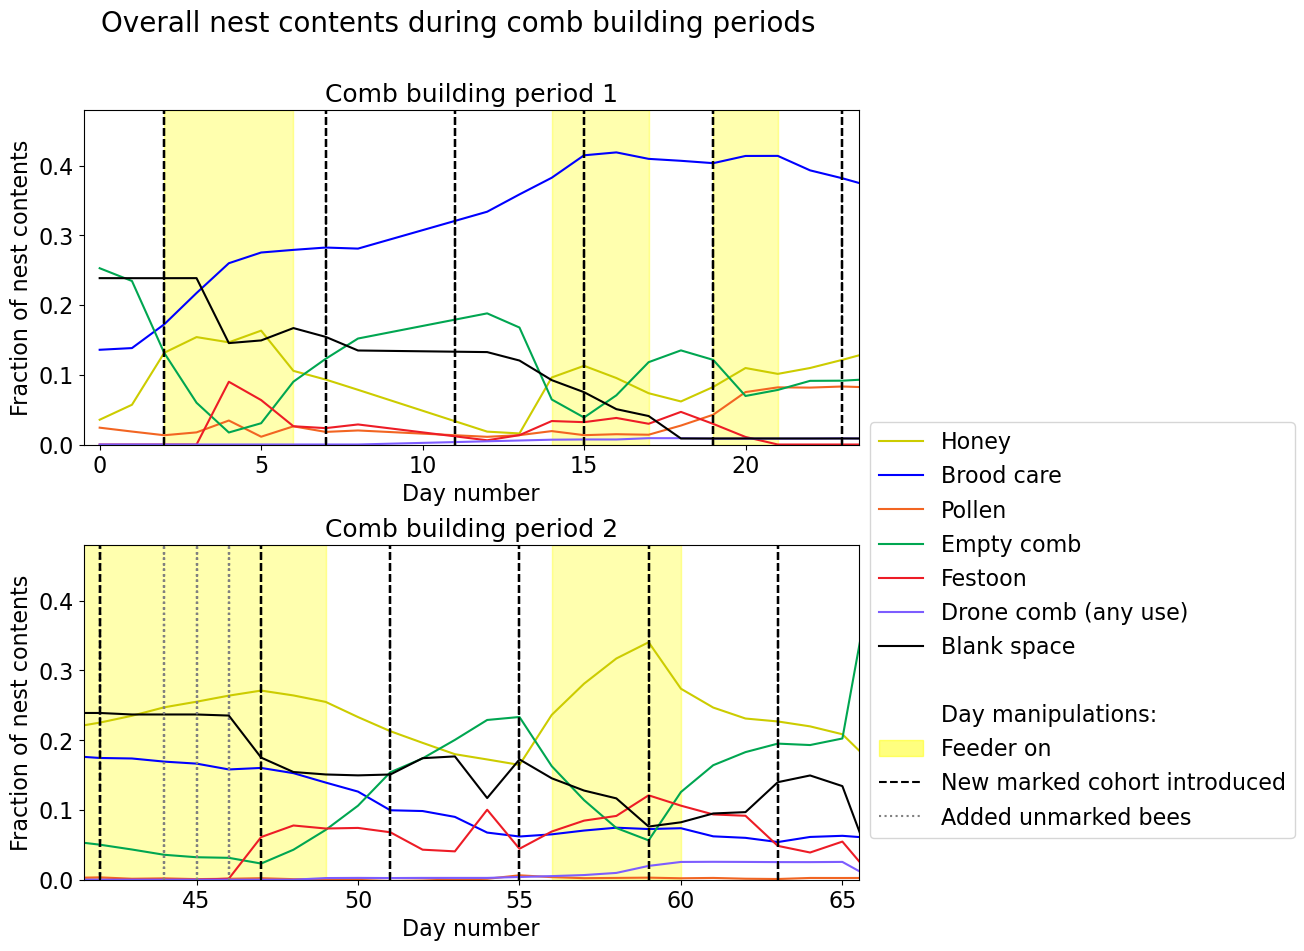

In [11]:
f,ax=plt.subplots(2,1)
f.set_size_inches(10,10)

for a in ax:
    for i in range(len(substrate_names_simple)-1):
        a.plot(all_substrates_simple[:,i],label=substrate_names_simple[i],color=substrate_colors_simple[i])
        [a.axvspan(d[0],d[1]+1,color='yellow',alpha=0.05,zorder=0) for d in feederon_ranges]
        [a.axvline(d,color='grey',linewidth=1.5,linestyle='dotted') for d in addedbees_days]
        [a.axvline(d,color='k',linewidth=1.5,linestyle='--') for d in addedcohorts_days]

# legend hack for feeder on and added bees
a=ax[0]
a.axvline(-2,color='grey',linewidth=0.01,alpha=0,linestyle='--',label=' ')
a.axvline(-2,color='grey',linewidth=0.01,alpha=0.0,linestyle='--',label='Day manipulations:')
a.axvspan(-2,-1,color='yellow',alpha=0.5,label='Feeder on')
a.axvline(-1,color='k',linewidth=1.5,linestyle='--',label='New marked cohort introduced')
a.axvline(-1,color='grey',linewidth=1.5,linestyle='dotted',label='Added unmarked bees')
ax[0].legend(bbox_to_anchor=(1,0.1),fontsize=16)

ax[0].set_xlim(combdays1[0]-0.5,combdays1[-1]+1.5)
ax[1].set_xlim(combdays2[0]-0.5,combdays2[-1]+1.5)
for a in ax:
    a.tick_params(labelsize=16)
    a.set_ylim([0,0.48])
    a.set_xlabel('Day number',fontsize=16)
    a.set_ylabel('Fraction of nest contents',fontsize=16)

ax[0].set_title('Comb building period 1',fontsize=18)
ax[1].set_title('Comb building period 2',fontsize=18)
plt.suptitle('Overall nest contents during comb building periods',fontsize=20)
plt.subplots_adjust(hspace=0.3)
# plt.savefig('image-output/comb-overall-contents.pdf')
plt.show()

## view the comb during these time periods

In [12]:
(combdays1,combdays2)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
        59, 60, 61, 62, 63, 64]))

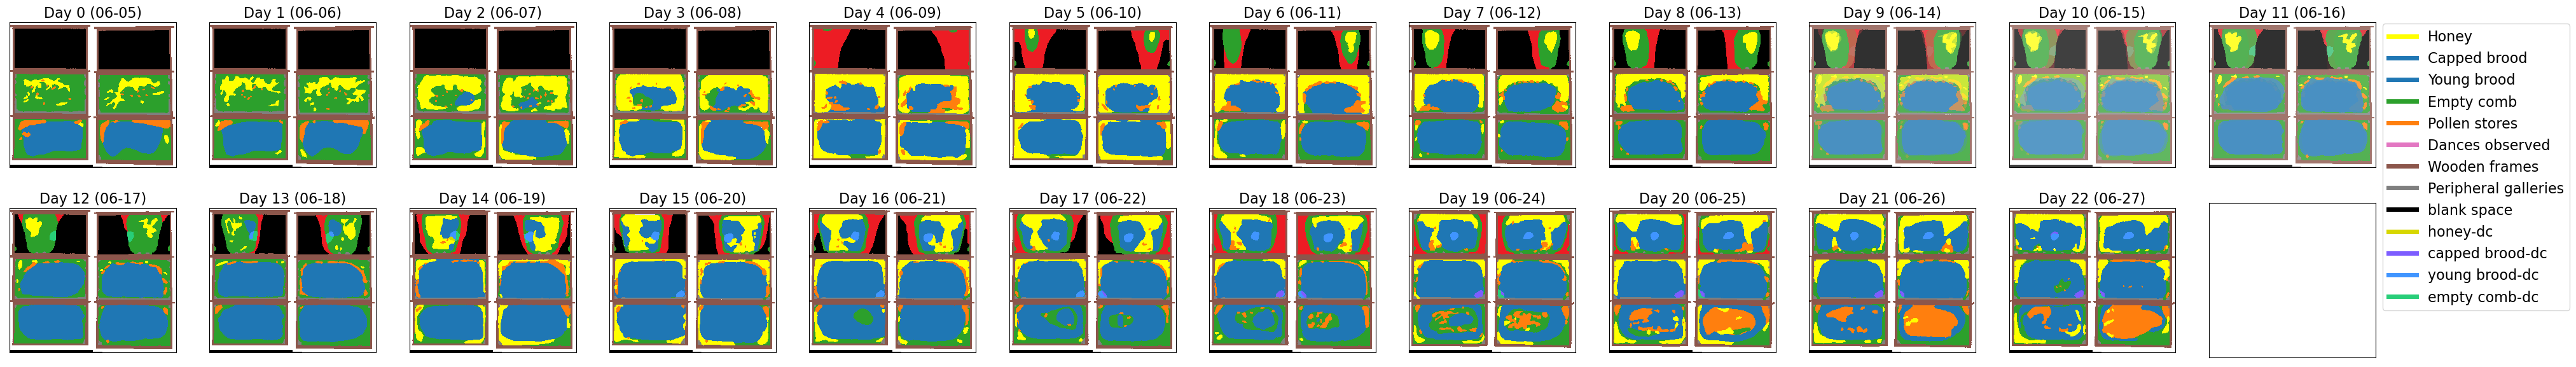

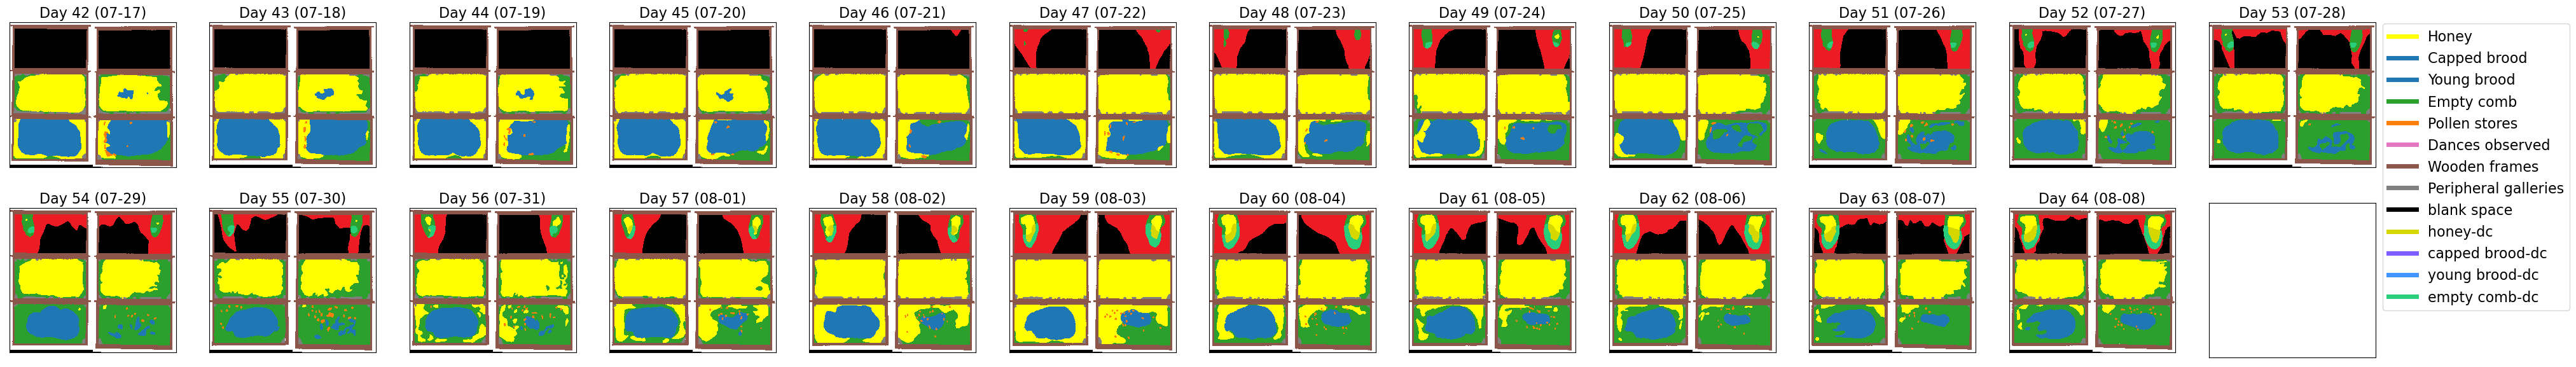

In [276]:

for daystoshow in [combdays1[::1],combdays2[::1]]:
    savename=''
    
    numrows=2
    numcols=int(np.ceil(len(daystoshow)/numrows))

    f,ax = plt.subplots(numrows,numcols,sharex=True,sharey=True)
    basesize=4
    fontsize=basesize*4
    f.set_size_inches(basesize*numcols,basesize*numrows*(bd.ypixels/(2*bd.xpixels)))
    f.set_facecolor('white')

    for i,daynum in enumerate(daystoshow):    
        a = ax[np.floor(i/ax.shape[1]).astype(int),np.mod(i,ax.shape[1])]
        comb = pickle.load(gzip.open(comb_contents_dir+'comb_'+str(daynum).zfill(zfilln)+'.pklz','rb'))
        bp.showcomb(comb,ax=a)
        # ax.scatter(2*xsize-combined_points[::50,1],combined_points[::50,0],alpha=0.01)
    #     hull_vertices = [hull.points[hull.vertices,0],hull.points[hull.vertices,1]]
    #     ax.plot(bd.xpixels+hull_vertices[1], hull_vertices[0], linestyle='--',lw=4,c=bd.cmap_comb(5))
        a.set_title('Day '+str(daynum)+ ' ('+bp.showmonthday(bd.alldaytimestamps[daynum])+')',fontsize=fontsize)

    # legend hack
    a = ax[0,-1]
    for i in range(len(bd.substrate_names)-2):
        if i==5:  # dance floor
            a.plot(0,0,label='Dances observed',c=bd.cmap_comb(i),lw=5)
    #         a.plot(0,0,label='Dance floor (combined)',linestyle='--',lw=5,c=bd.cmap_comb(i))        
        else:
            a.plot(0,0,label=bd.substrate_names[i],c=bd.cmap_comb(i),lw=5)
    a.legend(fontsize=fontsize,bbox_to_anchor=(1, 1.04),loc='upper left')
    plt.subplots_adjust(hspace=0.2)
    if not(savename==''):
        plt.savefig('image-output/'+savename+'.pdf')
        plt.savefig('image-output/'+savename+'.png')
    plt.show()